# 1- Exploration des données de tweets

Notre objectif est de réaliser un outil de détection de bad buzz pour Air Paradis.

Avant de débuter la modélisation, commençons par explorer nos données, un ensemble de tweets issu du [lien suivant](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+7%C2%A0-+D%C3%A9tectez+les+Bad+Buzz+gr%C3%A2ce+au+Deep+Learning/sentiment140.zip)

## 1 - Importations des librairies

In [1]:

# Librairies pour la manipulation et l'analyse des données
import pandas as pd
import numpy as np

# Librairies pour le traitement du langage naturel (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Librairies pour la visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Librairies pour la sauvegarde des données
import os
import pickle

# Téléchargement des ressources NLTK
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/mehdi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mehdi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 2. Chargement et aperçu des données

### 2.1 - Chargement & Extraction des données 

In [2]:

# Télécharger les données depuis un nouveau lien 
!wget -nc  -P ../data/raw "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+7%C2%A0-+D%C3%A9tectez+les+Bad+Buzz+gr%C3%A2ce+au+Deep+Learning/sentiment140.zip" 

# Décompresser le fichier zip
!unzip -n ../data/raw/sentiment140.zip -d ../data/raw

# Charger les données du fichier CSV
df = pd.read_csv('../data/raw/training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)

# Renommer les colonnes
df.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']


Fichier ‘../data/raw/sentiment140.zip’ déjà présent ; pas de récupération.

Archive:  ../data/raw/sentiment140.zip


### 2.2 - Aperçu des données

In [3]:
#@title 2.2 Aperçu des données

# Afficher les premières lignes du DataFrame
print("Premières lignes du DataFrame :")
display(df.head())

Premières lignes du DataFrame :


,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Les données sont des tweets sous forme de texte, des informations type metadata (date, user...), ainsi que le sentiment associé au tweet (positif ou négatif)

Dans le cadre de notre projet, seuls les features "sentiment" et "text" vont nous intéressés. Le reste n'est pas utile à notre analyse.

### 2.3 - Informations sur les données

In [4]:
# Afficher les types de données et les informations manquantes
print("\nInformations sur le DataFrame :")
df.info()


Informations sur le DataFrame :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   query      1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


### 2.4 - Statistiques descriptives

In [5]:
print("\nStatistiques descriptives (colonne sentiment):")
display(df["sentiment"].describe())


Statistiques descriptives (colonne sentiment):


count    1.600000e+06
mean     2.000000e+00
std      2.000001e+00
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      4.000000e+00
Name: sentiment, dtype: float64

Un total de 1,6 millions de tweets

## 3. Analyse exploratoire

### 3.1 - Distribution des classes (sentiment)

0 : sentiment négatif

4 : sentiment positif

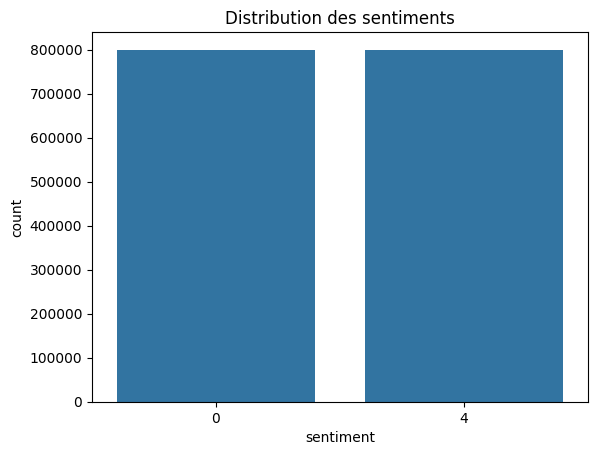

In [6]:
#@title 3.1 Distribution des classes


# Afficher la distribution des sentiments
sns.countplot(x='sentiment', data=df)
plt.title('Distribution des sentiments')
plt.show()

La distribution observée est équilibrée entre sentiment positif et négatif.

### 3.2 - Longueur des tweets

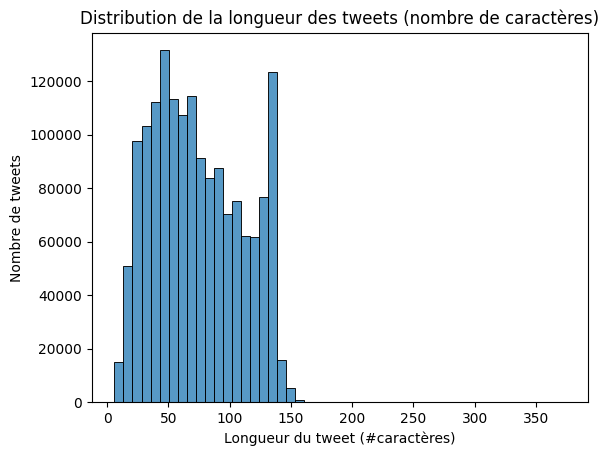

In [7]:
#@title 3.2 Longueur des tweets

# Calculer la longueur des tweets
df['longueur_tweet'] = df["text"].apply(len)

# Afficher la distribution de la longueur des tweets
sns.histplot(df['longueur_tweet'], bins=50)
plt.title('Distribution de la longueur des tweets (nombre de caractères)')
plt.xlabel('Longueur du tweet (#caractères)')
plt.ylabel('Nombre de tweets')
plt.show()

Les tweets sont relativement courts (limite de 280 caractères>) avec un mode à 140 caractères pour notre distribution. 
Cela peut poser un défi pour les algorithmes : peu de contexte pour que nos modèles de machine learning apprennent, d'autant que c'est un langage informel avec des emojis, fautes etc.

### 3.3 - Fréquence des mots

In [8]:
#@title 3.3 Fréquence des mots

from collections import Counter

# Joindre tous les tweets nettoyés en une seule chaîne de caractères
all_words = ' '.join(df["text"].tolist()).split()

# Filtrer les stop words
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in all_words if word.lower() not in stop_words]

# Compter les occurrences de chaque mot
word_counts = Counter(filtered_words)

# Affichage des 20 mots les plus fréquents
print("20 mots les plus fréquents :")
print(word_counts.most_common(20))


20 mots les plus fréquents :
[("I'm", 99559), ('get', 76734), ('like', 73302), ('-', 67079), ('go', 62969), ('good', 59775), ('day', 55748), ('got', 53871), ('going', 53236), ('love', 50051), ('work', 45913), ('back', 44033), ('u', 43568), ('really', 42152), ('see', 41343), ('know', 41338), ('one', 41082), ('&amp;', 40131), ('time', 39570), ('want', 39218)]


### 3.4 - Nuage de mots

#### Tweets positifs

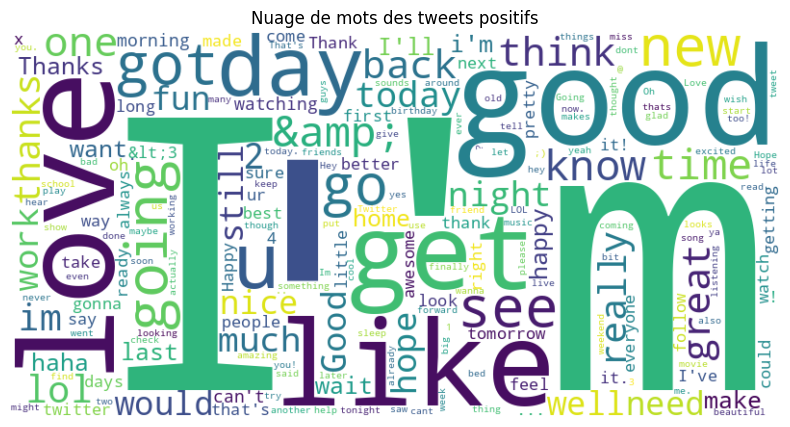

In [9]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Filtrer les tweets positifs
positive_tweets = df[df["sentiment"] == 4]["text"].tolist()

# Joindre tous les tweets positifs en une seule chaîne de caractères
all_words_positive = ' '.join(positive_tweets).split()

# Filtrer les stop words
stop_words = set(stopwords.words('english'))
filtered_words_positive = [word for word in all_words_positive if word.lower() not in stop_words]

# Compter les occurrences de chaque mot
word_counts_positive = Counter(filtered_words_positive)

# Créer un nuage de mots
wordcloud_positive = WordCloud(width=800,
                              height=400,
                              background_color='white').generate_from_frequencies(word_counts_positive)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots des tweets positifs')
plt.show()

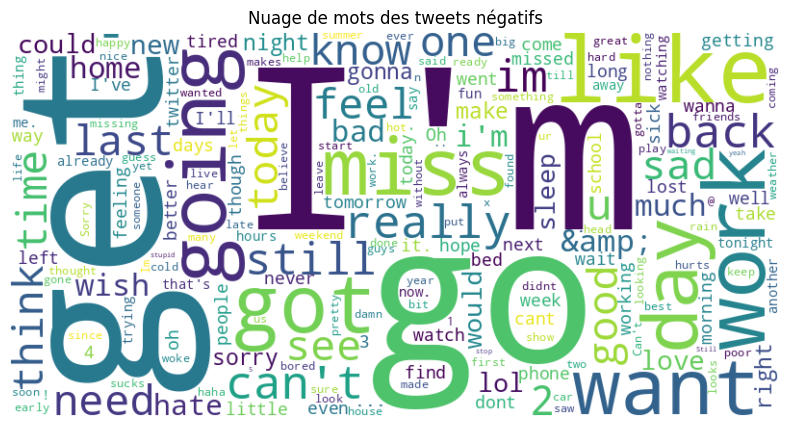

In [11]:
# Filtrer les tweets négatifs
negative_tweets = df[df["sentiment"] == 0]["text"].tolist()

# Joindre tous les tweets négatifs en une seule chaîne de caractères
all_words_negative = ' '.join(negative_tweets).split()

# Filtrer les stop words
filtered_words_negative = [word for word in all_words_negative if word.lower() not in stop_words]

# Compter les occurrences de chaque mot
word_counts_negative = Counter(filtered_words_negative)

# Créer un nuage de mots
wordcloud_negative = WordCloud(width=800,
                              height=400,
                              background_color='white').generate_from_frequencies(word_counts_negative)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots des tweets négatifs')
plt.show()

Quelques différences à relever entre les tweets négatifs et les tweets positifs.

- Tweet positifs : des mots comme like, good love, great, thanks 

- Tweet négatifs : hate, can't, sad, tired, miss. 

Ce n'est pas systématique sur l'ensemble mais permet d'envisager une première approche pour classifier les tweets.

## 4. Conclusion

Dans ce notebook, nous avons exploré les données de tweets en effectuant une analyse descriptive et une analyse exploratoire. 

Nous avons notamment observé :

* La distribution des sentiments (classes équilibrées).
* La longueur des tweets (distribution asymétrique).
* Les mots les plus fréquents
* Un nuage de mots pour visualiser les termes importants (tweets positifs et négatifs)

Ces analyses nous permettent d'identifier les challenges posés par les données.